# Instrukcja obsługi

1. Przenieś ten notebook na __GOOGLE Colab__
2. Wybierz środowisko uruchomieniowe z __GPU__
3. Zainstaluj potrzebne paczki
4. Pobierz dane udostępnione na google drive
5. Zapoznaj się ze wstępem teoretycznym
6. Wykonaj ćwiczenia
7. Wynik (plik video) pobierz na dysk i zweryfikuj wyniki

In [1]:
!pip install tensorflow-gpu==1.13.1 opencv-python numpy matplotlib tqdm googledrivedownloader

     |████████████████████████████████| 345.2MB 31kB/s 
     |████████████████████████████████| 3.2MB 16.8MB/s 
     |████████████████████████████████| 368kB 24.5MB/s 
ERROR: tensorflow 2.2.0rc4 has requirement tensorboard<2.3.0,>=2.2.0, but you'll have tensorboard 1.13.1 which is incompatible.
ERROR: tensorflow 2.2.0rc4 has requirement tensorflow-estimator<2.3.0,>=2.2.0, but you'll have tensorflow-estimator 1.13.0 which is incompatible.
  Found existing installation: tensorboard 2.2.1
    Uninstalling tensorboard-2.2.1:
      Successfully uninstalled tensorboard-2.2.1
  Found existing installation: tensorflow-estimator 2.2.0
    Uninstalling tensorflow-estimator-2.2.0:
      Successfully uninstalled tensorflow-estimator-2.2.0


In [7]:
from google_drive_downloader import GoogleDriveDownloader as gdd


FILES = [
    ("1fUfnAgTiCTwO88rXf6sWaX8Q2CVwQKZc", "./icnet_arch.png"),
    ("1hTr7IdgyZav6HrxHeD3yYiw2dpom4ljt", "./example_image.png"),
    ("1uprqCkWk4nJIXTXE8T7VRs57FuCI_bOg", "./checkpoint.ckpt-320.meta"),
    ("1DtVkR8gzz1TwSrmoTMQ4Ce5ckMJT-dm1", "./checkpoint.ckpt-320.index"),
    ("1KI017FbcT9Fi7Ewx3_AwhYRK17YQNs7c", "./checkpoint.ckpt-320.data-00000-of-00001"),
    ("1uy8SXke1NgmAEvpIKd5WOT_4ktSkP9dz", "./big_stuttgart_01.avi"),
    ("1-MHaZsnidOaTQ1GolIglTX6YDTowXeI6", "./atrous_pyramid_encoder.png"),
]

for file_id, file_name in FILES:
    gdd.download_file_from_google_drive(
        file_id=file_id,
        dest_path=file_name,
        unzip=False
    )


In [8]:
!ls

atrous_pyramid_encoder.png		 example_image.png
big_stuttgart_01.avi			 icnet_arch_.png
checkpoint.ckpt-320.data-00000-of-00001  icnet_arch.png
checkpoint.ckpt-320.index		 sample_data
checkpoint.ckpt-320.meta


In [0]:
from typing import List, Union, Optional, Tuple, Generator
from enum import Enum
from functools import partial
import time

In [0]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2 as cv
from tqdm import tqdm

# Wstęp teoretyczny i szczególy implementacyjne modelu

## Segmentacja semantyczna

Segmentacja semantyczna jest zagadnieniem Computer Vision, które polega na przypisnaiu dla każdego piksela obrazu klasy semantycznej, do której należy. Dla wejścia o wielkości (H, W, #color_channels) powstaje mapa segmentacji o wielkości (sH, sW) (s - współczynnik skalowania). Każdy element wyjściowej tablicy określa klasę semantyczną, do której należy odpowiadająca mu część obrazu wejściowego.

Dla przykładu:

![CityScapesExample](https://www.cityscapes-dataset.com/wordpress/wp-content/uploads/2015/07/zuerich00.png)

### Dane

Źródłem danych jest zbiór CityScapes: https://www.cityscapes-dataset.com/

## Definicja modelu

Model, któy będziemy używać jest lekką modyfikacją modelu zaprezentowanego w publikacji:

__ICNet for Real-Time Semantic Segmentation on High-Resolution Images, Hengshuang Zhao, Xiaojuan Qi, Xiaoyong Shen, Jianping Shi, Jiaya Jia__, https://arxiv.org/abs/1704.08545

Schemat konceptualny:


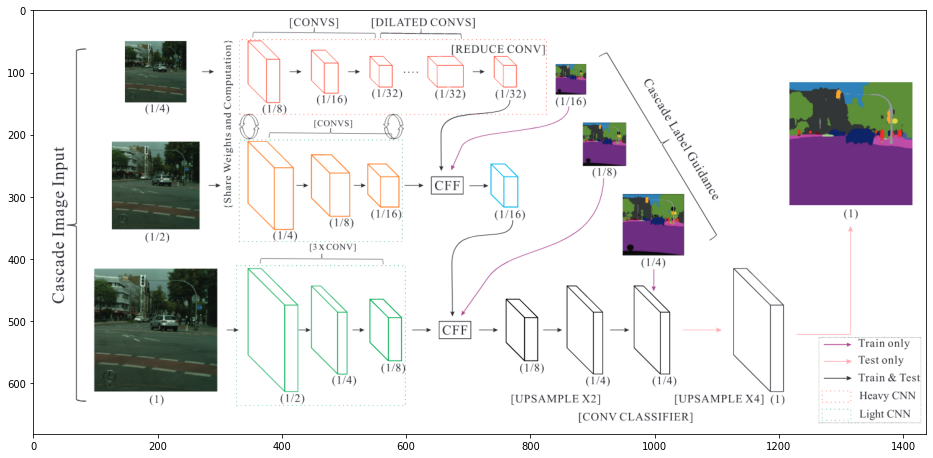

In [42]:
fig, ax = plt.subplots(figsize=(16, 9))
arch = cv.imread("icnet_arch.png")
ax.imshow(arch[:, :, ::-1])

### Utils

In [0]:
class FusionMethod(Enum):
    CONCAT = 0
    SUM = 1


ATROUS_ENCODER_PYRAMID_CFG_ERROR_MSG = \
    'Lists of pyramid_heads_dilation_rate and pyramid_heads_kernels must be ' \
    'equally long.'
ATROUS_ENCODER_RESIDUAL_ERROR_MSG = \
    'Input (or reducted input) do not fit the pyramid output in terms of ' \
    'filters number.'


class AtrousPyramidEncoderError(Exception):
    pass


def prepare_block_operation_name(base_name: str,
                                 operation_name: str,
                                 postfix: Optional[str] = None) -> str:
    if postfix is None:
        postfix = ''
    else:
        postfix = f'/{postfix}'
    return f'{base_name}/{operation_name}{postfix}'


### Warstwy

Funkcje, które stanowią wrappery na proste warstwy Tensorflow, pozwalają w bardziej kompaktowy sposób definiować finalny model.

In [0]:
def upsample_bilinear(x: tf.Tensor,
                      zoom_factor: int) -> tf.Tensor:
    return _interpolate(
        x=x,
        resize_factor=zoom_factor,
        resize_method=tf.image.ResizeMethod.BILINEAR)


def upsample_nn(x: tf.Tensor,
                zoom_factor: int) -> tf.Tensor:
    return _interpolate(
        x=x,
        resize_factor=zoom_factor,
        resize_method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)


def downsample_bilinear(x: tf.Tensor,
                        shrink_factor: int) -> tf.Tensor:
    resize_factor = 1 / shrink_factor
    return _interpolate(
        x=x,
        resize_factor=resize_factor,
        resize_method=tf.image.ResizeMethod.BILINEAR)


def downsample_nn(x: tf.Tensor,
                  shrink_factor: int) -> tf.Tensor:
    resize_factor = 1 / shrink_factor
    return _interpolate(
        x=x,
        resize_factor=resize_factor,
        resize_method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)


def _interpolate(x: tf.Tensor,
                 resize_factor: float,
                 resize_method: tf.image.ResizeMethod) -> tf.Tensor:
    if resize_factor >= 1:
        resize_factor = int(round(resize_factor))
        new_shape = x.shape[1] * resize_factor, x.shape[2] * resize_factor
    else:
        resize_factor = 1 / resize_factor
        resize_factor = int(round(resize_factor))
        new_shape = x.shape[1] // resize_factor, x.shape[2] // resize_factor
    return tf.image.resize_images(
        images=x,
        size=new_shape,
        method=resize_method,
        align_corners=True)

In [0]:
def bottleneck_conv2d(x: tf.Tensor,
                      num_filters: int,
                      strides: Tuple[int, int] = (1, 1),
                      activation: Optional[str] = 'relu',
                      padding: str = 'SAME',
                      name: Optional[str] = None,
                      **kwargs) -> tf.Tensor:
    """
    Convolution layer that change (usually reduce) filter numbers
    while preserving spatial dimensions.
    """
    return tf.layers.conv2d(
        inputs=x,
        filters=num_filters,
        kernel_size=(1, 1),
        strides=strides,
        padding=padding,
        activation=activation,
        name=name,
        *kwargs)


def downsample_conv2d(x: tf.Tensor,
                      num_filters: int,
                      kernel_size: Tuple[int, int],
                      strides: Tuple[int, int] = (2, 2),
                      activation: Optional[str] = 'relu',
                      name: Optional[str] = None,
                      padding: str = 'SAME',
                      **kwargs) -> tf.Tensor:
    """
    Convolution layer that reduce the spatial dimensions.
    """
    return tf.layers.conv2d(
        inputs=x,
        filters=num_filters,
        kernel_size=kernel_size,
        strides=strides,
        padding=padding,
        activation=activation,
        name=name,
        *kwargs)


def dim_hold_conv2d(x: tf.Tensor,
                    num_filters: int,
                    kernel_size: Tuple[int, int],
                    activation: Optional[str] = 'relu',
                    padding: str = 'SAME',
                    name: Optional[str] = None,
                    **kwargs) -> tf.Tensor:
    """
    Convolution layer that holds the spatial dimensions while
    performing convolution operation with given kernel.
    """
    return tf.layers.conv2d(
        inputs=x,
        filters=num_filters,
        kernel_size=kernel_size,
        padding=padding,
        activation=activation,
        name=name,
        *kwargs)


def atrous_conv2d(x: tf.Tensor,
                  num_filters: int,
                  kernel_size: Tuple[int, int],
                  dilation_rate: Tuple[int, int] = (2, 2),
                  activation: Optional[str] = 'relu',
                  padding: str = 'SAME',
                  name: Optional[str] = None,
                  **kwargs) -> tf.Tensor:
    return tf.layers.conv2d(
        inputs=x,
        filters=num_filters,
        kernel_size=kernel_size,
        dilation_rate=dilation_rate,
        padding=padding,
        activation=activation,
        name=name,
        *kwargs)


def separable_bottleneck_conv2d(x: tf.Tensor,
                                num_filters: int,
                                activation: Optional[str] = 'relu',
                                padding: str = 'SAME',
                                name: Optional[str] = None,
                                **kwargs) -> tf.Tensor:
    return separable_conv2d(x=x,
                            num_filters=num_filters,
                            kernel_size=(1, 1),
                            activation=activation,
                            padding=padding,
                            name=name,
                            *kwargs)


def separable_conv2d(x: tf.Tensor,
                     num_filters: int,
                     kernel_size: Tuple[int, int],
                     strides: Tuple[int, int] = (1, 1),
                     activation: Optional[str] = 'relu',
                     name: Optional[str] = None,
                     padding: str = 'SAME',
                     **kwargs) -> tf.Tensor:
    return tf.layers.separable_conv2d(
        inputs=x,
        filters=num_filters,
        kernel_size=kernel_size,
        strides=strides,
        padding=padding,
        activation=activation,
        name=name,
        *kwargs)


def atrous_separable_conv2d(x: tf.Tensor,
                            num_filters: int,
                            kernel_size: Tuple[int, int],
                            dilation_rate: Tuple[int, int] = (2, 2),
                            activation: Optional[str] = 'relu',
                            padding: str = 'SAME',
                            name: Optional[str] = None,
                            **kwargs) -> tf.Tensor:
    return tf.layers.separable_conv2d(
        inputs=x,
        filters=num_filters,
        kernel_size=kernel_size,
        dilation_rate=dilation_rate,
        padding=padding,
        activation=activation,
        name=name,
        *kwargs)


def pool2d(x: tf.Tensor,
           window_shape: Tuple[int, int],
           pooling_type: str,
           padding: str = 'SAME',
           strides: Optional[Tuple[int, int]] = None,
           dilation_rate: Optional[Tuple[int, int]] = None,
           name: Optional[str] = None,
           **kwargs) -> tf.Tensor:
    return tf.nn.pool(
        input=x,
        window_shape=window_shape,
        pooling_type=pooling_type,
        padding=padding,
        strides=strides,
        dilation_rate=dilation_rate,
        name=name,
        *kwargs
    )

### Bloki funkcjonalne modelu

Atrous/Dilated convolution:

![Atrous conv](https://github.com/vdumoulin/conv_arithmetic/blob/master/gif/dilation.gif?raw=true)

atrous_pyramid_encoder jest encoderem cech, który zobrazować można w następujący sposób:

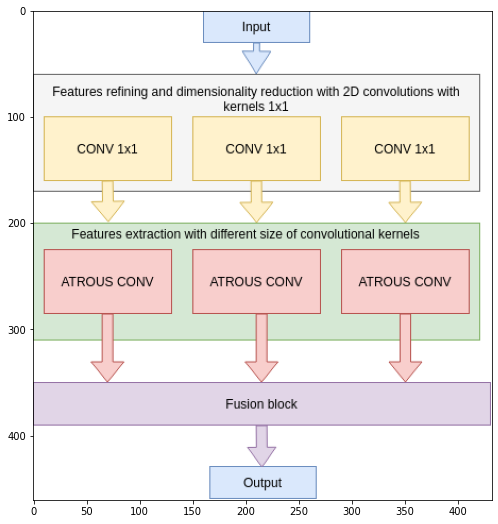

In [41]:
fig, ax = plt.subplots(figsize=(16, 9))
arch = cv.imread("atrous_pyramid_encoder.png")
ax.imshow(arch[:, :, ::-1])


Poniższego kodu nie trzeba analizować, został on napisany w sposób umożliwiający dostosowanie wielu parametrów, a zatem jest dość rozbudowany. Ważna jest jedynie istota działania, którą można streścić w sposób następujący:

W segmentacji semantycznej ważne jest osadzenie poszczególnych elementów obrazu w kontekście i wychwytywanie cech o różnym poziomie granularności - dla przykładu duża budowla w mieście to najprawdopodobniej budynek mieszkalny, a w strefie przemysłowej to fabryka. Dodanie piramid do modelu miało na celu rozszerzenie "receptive field" (pola widzeinia kernala konwolucji) a także ekstrakcję i łączenie cech o róznych "rozmiarach". 

In [0]:
def atrous_pyramid_encoder(x: tf.Tensor,
                           output_filters: int,
                           pyramid_heads_dilation_rate: List[int],
                           pyramid_heads_kernels: Union[int, List[int]] = 3,
                           use_separable_conv_in_pyramid: bool = False,
                           pyramid_heads_activations: Optional[str] = 'relu',
                           input_filters_after_reduction: Optional[int] = 64,
                           separate_reduction_head: bool = True,
                           use_separable_conv_on_input: bool = False,
                           reduction_activation: Optional[str] = 'relu',
                           use_residual_connection: bool = True,
                           fusion_method: FusionMethod = FusionMethod.SUM,
                           fusion_blending_kernel: Optional[int] = 3,
                           use_separable_conv_while_fusion: bool = False,
                           fusion_activation: Optional[str] = 'relu',
                           name: Optional[str] = None) -> tf.Tensor:
    _validate_atrous_encoder_input(
        x=x,
        pyramid_heads_dilation_rate=pyramid_heads_dilation_rate,
        pyramid_heads_kernels=pyramid_heads_kernels,
        use_residual_connection=use_residual_connection,
        input_filters_after_reduction=input_filters_after_reduction,
        output_filters=output_filters)
    heads_number = len(pyramid_heads_dilation_rate)
    inputs = _atrous_encoder_input(
        x=x,
        heads_number=heads_number,
        input_filters_after_reduction=input_filters_after_reduction,
        separate_reduction_head=separate_reduction_head,
        reduction_activation=reduction_activation,
        use_separable_conv_on_input=use_separable_conv_on_input,
        name=name)
    pyramid_output = _atrous_pyramid(
        inputs=inputs,
        output_filters=output_filters,
        heads_dilation_rate=pyramid_heads_dilation_rate,
        heads_kernels=pyramid_heads_kernels,
        use_separable_conv_in_pyramid=use_separable_conv_in_pyramid,
        pyramid_heads_activations=pyramid_heads_activations,
        name=name)
    output_is_last_op_in_block = not use_residual_connection
    out = _output_fusion(
        pyramid_output=pyramid_output,
        output_filters=output_filters,
        fusion_method=fusion_method,
        fusion_blending_kernel=fusion_blending_kernel,
        use_separable_conv_while_fusion=use_separable_conv_while_fusion,
        fusion_activation=fusion_activation,
        name=name,
        output_is_last_op_in_block=output_is_last_op_in_block
    )
    if use_residual_connection:
        if name is not None:
            name = prepare_block_operation_name(name, 'out')
        out = tf.math.add(out, x, name=name)
    return out


def _validate_atrous_encoder_input(x: tf.Tensor,
                                   pyramid_heads_dilation_rate: List[int],
                                   pyramid_heads_kernels: Union[int, List[int]],
                                   use_residual_connection: bool,
                                   input_filters_after_reduction: Optional[int],
                                   output_filters: int) -> None:
    _check_pyramid_input(pyramid_heads_dilation_rate, pyramid_heads_kernels)
    _check_residual_connection(
        x,
        use_residual_connection,
        input_filters_after_reduction,
        output_filters)


def _check_pyramid_input(pyramid_heads_dilation_rate: List[int],
                         pyramid_heads_kernels: Union[int, List[int]]) -> None:
    if isinstance(pyramid_heads_kernels, list):
        if len(pyramid_heads_dilation_rate) != len(pyramid_heads_kernels):
            raise AtrousPyramidEncoderError(
                ATROUS_ENCODER_PYRAMID_CFG_ERROR_MSG
            )
    return None


def _check_residual_connection(x: tf.Tensor,
                               use_residual_connection: bool,
                               input_filters_after_reduction: Optional[int],
                               output_filters: int) -> None:
    if not use_residual_connection:
        return None
    if input_filters_after_reduction is None:
        if x.shape[-1] != output_filters:
            raise AtrousPyramidEncoderError(ATROUS_ENCODER_RESIDUAL_ERROR_MSG)
        else:
            return None
    elif input_filters_after_reduction != output_filters:
        raise AtrousPyramidEncoderError(ATROUS_ENCODER_RESIDUAL_ERROR_MSG)
    return None


def _atrous_encoder_input(x: tf.Tensor,
                          heads_number: int,
                          input_filters_after_reduction: Optional[int] = 64,
                          separate_reduction_head: bool = True,
                          reduction_activation: Optional[str] = 'relu',
                          use_separable_conv_on_input: bool = False,
                          name: Optional[str] = None) -> List[tf.Tensor]:
    if input_filters_after_reduction is None:
        return [x for _ in range(heads_number)]
    create_input_head = partial(
        _atrous_encoder_input_head,
        x=x,
        filters=input_filters_after_reduction,
        activation=reduction_activation,
        use_separable_conv=use_separable_conv_on_input,
        name=name)
    if separate_reduction_head is True:
        return [create_input_head(head_id=i) for i in range(heads_number)]
    else:
        input_head = create_input_head(0)
        return [input_head for _ in range(heads_number)]
    
    
def _atrous_encoder_input_head(x: tf.Tensor,
                               filters: int,
                               activation: Optional[str],
                               use_separable_conv: bool,
                               name: Optional[str],
                               head_id: Optional[str]) -> tf.Tensor:
    if name is not None:
        name = prepare_block_operation_name(
            name,
            'input_head',
            f'reduction_1x1_conv_{head_id}')
    if use_separable_conv:
        return separable_bottleneck_conv2d(
            x,
            filters,
            activation=activation,
            name=name)
    else:
        return bottleneck_conv2d(
            x,
            filters,
            activation=activation,
            name=name)


def _atrous_pyramid(inputs: List[tf.Tensor],
                    output_filters: int,
                    heads_dilation_rate: List[int],
                    heads_kernels: Union[int, List[int]],
                    use_separable_conv_in_pyramid: bool,
                    pyramid_heads_activations: Optional[str],
                    name: Optional[str]) -> List[tf.Tensor]:
    if isinstance(heads_kernels, int):
        heads_no = len(heads_dilation_rate)
        heads_kernels = [heads_kernels for _ in range(heads_no)]
    pyramid_output = []
    builing_it = enumerate(zip(inputs, heads_kernels, heads_dilation_rate))
    for head_id, (x, kernel, dilation) in builing_it:
        pyramid_head = _atrous_pyramid_head(
            x=x,
            output_filters=output_filters,
            kernel=kernel,
            dilation_rate=dilation,
            use_separable_conv=use_separable_conv_in_pyramid,
            activation=pyramid_heads_activations,
            name=name,
            head_id=head_id
        )
        pyramid_output.append(pyramid_head)
    return pyramid_output


def _atrous_pyramid_head(x: tf.Tensor,
                         output_filters: int,
                         kernel: int,
                         dilation_rate: int,
                         use_separable_conv: bool,
                         activation: Optional[str],
                         name: Optional[str],
                         head_id: int) -> tf.Tensor:
    if name is not None:
        name = prepare_block_operation_name(
            name,
            'pyramid',
            f'{kernel}x{kernel}_conv_{head_id}')
    kernel = kernel, kernel
    dilation_rate = dilation_rate, dilation_rate
    if use_separable_conv:
        return atrous_separable_conv2d(
            x=x,
            num_filters=output_filters,
            kernel_size=kernel,
            dilation_rate=dilation_rate,
            activation=activation,
            name=name
        )
    else:
        return atrous_conv2d(
            x=x,
            num_filters=output_filters,
            kernel_size=kernel,
            dilation_rate=dilation_rate,
            activation=activation,
            name=name
        )


def _output_fusion(pyramid_output: List[tf.Tensor],
                   output_filters: int,
                   fusion_method: FusionMethod,
                   fusion_blending_kernel: Optional[int],
                   use_separable_conv_while_fusion: bool,
                   fusion_activation: Optional[str],
                   name: Optional[str],
                   output_is_last_op_in_block: bool) -> tf.Tensor:
    fused = _fusion_op(
        pyramid_output=pyramid_output,
        fusion_method=fusion_method,
        fusion_blending_kernel=fusion_blending_kernel,
        name=name,
        output_is_last_op_in_block=output_is_last_op_in_block)
    if fusion_blending_kernel is None:
        return fused
    return _blending_layer(
        x=fused,
        output_filters=output_filters,
        kernel=fusion_blending_kernel,
        use_separable_conv=use_separable_conv_while_fusion,
        activation=fusion_activation,
        name=name,
        output_is_last_op_in_block=output_is_last_op_in_block)


def _fusion_op(pyramid_output: List[tf.Tensor],
               fusion_method: FusionMethod,
               fusion_blending_kernel: Optional[int],
               name: Optional[str],
               output_is_last_op_in_block: bool) -> tf.Tensor:
    fusion_name = None
    if name is not None:
        concat_is_final_op = output_is_last_op_in_block and \
                             fusion_blending_kernel is None
        fusion_name_postfix = 'out' if concat_is_final_op else 'fusion'
        fusion_name = prepare_block_operation_name(name, fusion_name_postfix)
    if fusion_method is FusionMethod.SUM:
        fused = tf.math.add_n(pyramid_output, name=fusion_name)
    else:
        fused = tf.concat(pyramid_output, axis=-1, name=fusion_name)
    return fused


def _blending_layer(x: tf.Tensor,
                    output_filters: int,
                    kernel: int,
                    use_separable_conv: bool,
                    activation: Optional[str],
                    name: Optional[str],
                    output_is_last_op_in_block: bool) -> tf.Tensor:
    blending_name = None
    if name is not None:
        blending_postfix = 'out' if output_is_last_op_in_block else 'blend'
        blending_name = prepare_block_operation_name(name, blending_postfix)
    kernel = kernel, kernel
    if use_separable_conv is True:
        return separable_conv2d(
            x=x,
            num_filters=output_filters,
            kernel_size=kernel,
            activation=activation,
            name=blending_name)
    else:
        return dim_hold_conv2d(
            x=x,
            num_filters=output_filters,
            kernel_size=kernel,
            activation=activation,
            name=blending_name)


In [0]:
def pyramid_pool_fusion(x: tf.Tensor,
                        windows_shapes: List[int],
                        fuse_filters: int,
                        fuse_kernel: Tuple[int, int] = (3, 3),
                        pooling_type: str = 'AVG',
                        pooling_strides: Tuple[int, int] = (2, 2),
                        fusion_method: FusionMethod = FusionMethod.CONCAT,
                        name: Optional[str] = None) -> tf.Tensor:
    """
    Layer performs pooling operation with rectangular kernels according to
    :windows_shapes parameter. After that - pooling results are being
    concatenated along channel dimension and fusion operation (conv2d with
    strides=(1,1) and kernel size given by :fuse_kernel) is being applied.
    """

    def __prepare_pooling_layer(layer_parameters: Tuple[int, int]) -> tf.Tensor:
        pool_layer_id, window_shape = layer_parameters
        return pool2d(
            x,
            window_shape=(window_shape, window_shape),
            pooling_type=pooling_type,
            strides=pooling_strides,
            name=__pooling_name_assigner(pool_layer_id))

    def __pooling_name_assigner(pool_layer_id: int) -> Optional[str]:
        if name is None:
            return None
        else:
            return f'{name}/pooling_{pool_layer_id}'

    enumerated_shapes = list(enumerate(windows_shapes))
    pooling_layers = list(map(__prepare_pooling_layer, enumerated_shapes))
    if fusion_method is FusionMethod.CONCAT:
        fusion = tf.concat(pooling_layers, axis=-1)
    else:
        fusion = reduce(lambda acc, elem: acc + elem, pooling_layers)
    fuse_conv_name = f'{name}/fuse_conv' if name is not None else None
    return dim_hold_conv2d(
        x=fusion,
        num_filters=fuse_filters,
        kernel_size=fuse_kernel,
        name=fuse_conv_name)


### Model

In [0]:
class ICNetV12:
    
    def __init__(self,
                 output_classes: int,
                 image_mean: Optional[List[float]] = None
                ):
        self.__output_classes = output_classes
        self.__image_mean = None
        if image_mean is not None and len(image_mean) is 3:
            mean_tensor = tf.convert_to_tensor(
                image_mean,
                dtype=tf.float32)
            self.__image_mean = tf.expand_dims(mean_tensor, axis=0)
            
    def infer(self, x: tf.Tensor) -> tf.Tensor:
        """Returns tensor of size (N, H, W) as a semantic class map"""
        return self.feed_forward(
            x=x,
            is_training=False
        )

    def feed_forward(self,
                     x: tf.Tensor,
                     is_training: bool = False
                    ) -> tf.Tensor:
        if self.__image_mean is not None:
            x -= self.__image_mean
        x = tf.math.divide(x, 255.0)
        big_branch_output = self.__big_images_branch(
            x=x,
            is_training=is_training
        )
        half_size_input = downsample_bilinear(x=x, shrink_factor=2)
        medium_branch_common = self.__medium_branch_head(
            x=half_size_input,
            is_training=is_training
        )
        medium_branch_tail = self.__medium_branch_tail(
            x=medium_branch_common,
            is_training=is_training
        )
        small_branch_output = self.__small_branch(
            x=medium_branch_common,
            is_training=is_training
        )
        medium_small_fusion = self.__medium_small_branch_fusion(
            small_branch_output=small_branch_output,
            medium_branch_output=medium_branch_tail,
            is_training=is_training
        )
        big_medium_fusion = self.__big_medium_branch_fusion(
            fused_medium_branch=medium_small_fusion,
            big_branch_outtput=big_branch_output,
            is_training=is_training
        )
        cls = self.__prediction_branch(big_medium_fusion=big_medium_fusion)
        cls_up = upsample_bilinear(
            x=cls,
            zoom_factor=4
        )
        return tf.math.argmax(cls_up, axis=3, output_type=tf.dtypes.int32)
 
    def __big_images_branch(self,
                            x: tf.Tensor,
                            is_training: bool = True) -> tf.Tensor:
        h1_sub1 = downsample_conv2d(
            x=x,
            num_filters=8,
            kernel_size=(3, 3),
            name='h1_sub1'
        )
        h1_sub2 = downsample_conv2d(
            x=h1_sub1,
            num_filters=16,
            kernel_size=(3, 3),
            name='h1_sub2'
        )
        h1_sub3 = downsample_conv2d(
            x=h1_sub2,
            num_filters=64,
            kernel_size=(3, 3),
            name='h1_sub3'
        )
        return tf.layers.batch_normalization(
            inputs=h1_sub3,
            training=is_training,
            name='h1_sub3_bn'
        )
    

    def __medium_branch_head(self,
                             x: tf.Tensor,
                             is_training: bool
                             ) -> tf.Tensor:
        h2_sub1 = downsample_conv2d(
            x=x,
            num_filters=16,
            kernel_size=(3, 3),
            name='h2_sub1'
        )
        h2_conv1 = dim_hold_conv2d(
            x=h2_sub1,
            num_filters=16,
            kernel_size=(3, 3),
            name='h2_conv1'
        )
        h2_conv1_bn = tf.layers.batch_normalization(
            inputs=h2_conv1,
            training=is_training,
            name='h2_conv1_bn'
        )
        h2_sub2 = downsample_conv2d(
            x=h2_conv1_bn,
            num_filters=32,
            kernel_size=(3, 3),
            name='h2_sub2'
        )
        h2_conv2 = dim_hold_conv2d(
            x=h2_sub2,
            num_filters=64,
            kernel_size=(3, 3),
            name='h2_conv2'
        )
        return tf.layers.batch_normalization(
            inputs=h2_conv2,
            training=is_training,
            name='h2_conv2_bn'
        )
    
    def __medium_branch_tail(self,
                             x: tf.Tensor,
                             is_training: bool
                             ) -> tf.Tensor:
        h2_fs1 = bottleneck_conv2d(
            x=x,
            num_filters=64,
            name='h2_fs1'
        )
        h2_fs_bn = tf.layers.batch_normalization(
            inputs=h2_fs1,
            training=is_training,
            name='h2_fs_bn'
        )
        h2_conv3 = dim_hold_conv2d(
            x=h2_fs_bn,
            num_filters=128,
            kernel_size=(3, 3),
            name='h2_conv3'
        )
        h2_fs2 = bottleneck_conv2d(
            x=h2_conv3,
            num_filters=64,
            name='h2_fs2'
        )
        h2_conv4 = dim_hold_conv2d(
            x=h2_fs2,
            num_filters=128,
            kernel_size=(3, 3),
            name='h2_conv4'
        )
        h2_fs3 = bottleneck_conv2d(
            x=h2_conv4,
            num_filters=64,
            name='h2_fs3'
        )
        fuse = h2_fs1 + h2_fs3
        fuse_bn = tf.layers.batch_normalization(
            inputs=fuse,
            training=is_training,
            name='fuse_bn'
        )
        pp1 = pyramid_pool_fusion(
            x=fuse_bn,
            windows_shapes=[2, 3, 5],
            fuse_filters=128,
            name='h2_pp1'
        )
        dilated_block1 = atrous_pyramid_encoder(
            x=pp1,
            output_filters=128,
            pyramid_heads_dilation_rate=[1, 2, 4, 8],
            use_residual_connection=False,
            name='h2_dilation_block'
        )
        h2_dilated_block1_bn = tf.layers.batch_normalization(
            inputs=dilated_block1,
            training=is_training,
            name='h2_dilated_block1_bn'
        )
        h2_fs4 = bottleneck_conv2d(
            x=h2_dilated_block1_bn,
            num_filters=64,
            name='h2_fs4'
        )
        h2_conv5 = dim_hold_conv2d(
            x=h2_fs4,
            num_filters=128,
            kernel_size=(3, 3),
            name='h2_conv5'
        )
        h2_fs5 = bottleneck_conv2d(
            x=h2_conv5,
            num_filters=64,
            name='h2_fs5'
        )
        h2_conv6 = dim_hold_conv2d(
            x=h2_fs5,
            num_filters=256,
            kernel_size=(3, 3),
            name='h2_conv6'
        )
        h2_fs6 = bottleneck_conv2d(
            x=h2_conv6,
            num_filters=128,
            name='h2_fs6'
        )
        return tf.math.add(h2_fs6, pp1, name='h2_add')
    
    def __small_branch(self, x: tf.Tensor, is_training: bool) -> tf.Tensor:
        h3_fs1 = bottleneck_conv2d(x=x, num_filters=64, name='h3_fs1')
        h3_fs1_bn = tf.layers.batch_normalization(
            inputs=h3_fs1,
            training=is_training,
            name='h3_fs1_bn'
        )
        h3_pp1 = pyramid_pool_fusion(
            x=h3_fs1_bn,
            windows_shapes=[2, 3, 5],
            fuse_filters=128,
            name='h2_pp1'
        )
        h3_fs2 = bottleneck_conv2d(x=h3_pp1, num_filters=64, name='h3_fs2')
        h3_conv1 = dim_hold_conv2d(
            x=h3_fs2,
            num_filters=128,
            kernel_size=(3, 3),
            name='h3_conv1'
        )
        h3_fs3 = bottleneck_conv2d(x=h3_conv1, num_filters=64, name='h3_fs3')
        h3_conv2 = dim_hold_conv2d(
            x=h3_fs3,
            num_filters=256,
            kernel_size=(3, 3),
            name='h3_conv2'
        )
        h3_fs4 = bottleneck_conv2d(x=h3_conv2, num_filters=128, name='h3_fs4')
        h3_add1 = tf.math.add(h3_pp1, h3_fs4, name='h3_add1')
        h3_conv3 = dim_hold_conv2d(
            x=h3_add1,
            num_filters=256,
            kernel_size=(3, 3),
            name='h3_conv3'
        )
        h3_fs5 = bottleneck_conv2d(x=h3_conv3, num_filters=128, name='h3_fs5')
        h3_fs5_bn = tf.layers.batch_normalization(
            inputs=h3_fs5,
            training=is_training,
            name='h3_fs5_bn'
        )

        h3_pp2 = pyramid_pool_fusion(
            x=h3_fs5_bn,
            windows_shapes=[2, 3, 5],
            fuse_filters=256,
            name='h3_pp2'
        )
        h3_dilated_block_1 = atrous_pyramid_encoder(
            x=h3_pp2,
            output_filters=256,
            pyramid_heads_dilation_rate=[1, 2, 4, 8],
            use_residual_connection=False,
            name='h3_dilation_block_1'
        )
        h3_dilated_block_1_bn = tf.layers.batch_normalization(
            inputs=h3_dilated_block_1,
            training=is_training,
            name='h3_dilated_block_1_bn'
        )
        h3_fs6 = bottleneck_conv2d(
            x=h3_dilated_block_1_bn,
            num_filters=64,
            name='h3_fs6'
        )
        h3_conv4 = dim_hold_conv2d(
            x=h3_fs6,
            num_filters=256,
            kernel_size=(3, 3),
            name='h3_conv4'
        )
        h3_fs7 = bottleneck_conv2d(
            x=h3_conv4,
            num_filters=64,
            name='h3_fs7'
        )
        h3_conv5 = dim_hold_conv2d(
            x=h3_fs7,
            num_filters=512,
            kernel_size=(3, 3),
            name='h3_conv5'
        )
        h3_fs8 = bottleneck_conv2d(
            x=h3_conv5,
            num_filters=256,
            name='h3_fs8'
        )
        h3_add2 = tf.math.add(h3_pp2, h3_fs8, name='h3_add2')
        h3_add2_bn = tf.layers.batch_normalization(
            inputs=h3_add2,
            training=is_training,
            name='h3_add2_bn'
        )

        h3_fs9 = bottleneck_conv2d(
            x=h3_add2_bn,
            num_filters=128,
            name='h3_fs9'
        )
        h3_conv6 = dim_hold_conv2d(
            x=h3_fs9,
            num_filters=512,
            kernel_size=(3, 3),
            name='h3_conv6'
        )
        h3_fs10 = bottleneck_conv2d(
            x=h3_conv6,
            num_filters=128,
            name='h3_fs10'
        )
        h3_add3 = tf.math.add(h3_fs9, h3_fs10, name='h3_add3')
        h3_add3_bn = tf.layers.batch_normalization(
            inputs=h3_add3,
            training=is_training,
            name='h3_add3_bn'
        )
        h3_conv7 = dim_hold_conv2d(
            x=h3_add3_bn,
            num_filters=512,
            kernel_size=(3, 3),
            name='h3_conv7'
        )
        h3_fs11 = bottleneck_conv2d(
            x=h3_conv7,
            num_filters=128,
            name='h3_fs11'
        )
        h3_conv8 = dim_hold_conv2d(
            x=h3_fs11,
            num_filters=512,
            kernel_size=(3, 3),
            name='h3_conv8'
        )
        h3_fs12 = bottleneck_conv2d(
            x=h3_conv8,
            num_filters=128,
            name='h3_fs12'
        )
        h3_add4 = tf.math.add(h3_fs12, h3_add3_bn, name='h3_add4')
        h3_add4_bn = tf.layers.batch_normalization(
            inputs=h3_add4,
            training=is_training,
            name='h3_add4_bn'
        )
        h3_conv9 = dim_hold_conv2d(
            x=h3_add4_bn,
            num_filters=768,
            kernel_size=(3, 3),
            name='h3_conv9'
        )
        h3_fs13 = bottleneck_conv2d(
            x=h3_conv9,
            num_filters=128,
            name='h3_fs13'
        )
        h3_conv10 = dim_hold_conv2d(
            x=h3_fs13,
            num_filters=768,
            kernel_size=(3, 3),
            name='h3_conv10'
        )
        h3_fs14 = bottleneck_conv2d(
            x=h3_conv10,
            num_filters=128,
            name='h3_fs14'
        )
        h3_add5 = tf.math.add(h3_fs14, h3_add4_bn, name='h3_add5')
        h3_add5_bn = tf.layers.batch_normalization(
            inputs=h3_add5,
            training=is_training,
            name='h3_add5_bn'
        )
        h3_conv11 = dim_hold_conv2d(
            x=h3_add5_bn,
            num_filters=1024,
            kernel_size=(3, 3),
            name='h3_conv11'
        )
        h3_fs15 = bottleneck_conv2d(
            x=h3_conv11,
            num_filters=256,
            name='h3_fs15'
        )
        h3_conv12 = dim_hold_conv2d(
            x=h3_fs15,
            num_filters=1024,
            kernel_size=(3, 3),
            name='h3_conv12'
        )
        h3_fs16 = bottleneck_conv2d(
            x=h3_conv12,
            num_filters=256,
            name='h3_fs16'
        )
        h3_add6 = tf.math.add(h3_fs15, h3_fs16, name='h3_add6')
        return tf.layers.batch_normalization(
            inputs=h3_add6,
            training=is_training,
            name='h3_add6_bn'
        )
    
    def __medium_small_branch_fusion(self,
                                     small_branch_output: tf.Tensor,
                                     medium_branch_output: tf.Tensor,
                                     is_training: bool) -> tf.Tensor:
        return self.__cascade_fusion_block(
            smaller_input=small_branch_output,
            bigger_input=medium_branch_output,
            is_training=is_training,
            output_filters=64,
            base_name='medium_small_fusion'
        )
    
    def __big_medium_branch_fusion(self,
                                   fused_medium_branch: tf.Tensor,
                                   big_branch_outtput: tf.Tensor,
                                   is_training: bool) -> tf.Tensor:
        return self.__cascade_fusion_block(
            smaller_input=fused_medium_branch,
            bigger_input=big_branch_outtput,
            is_training=is_training,
            output_filters=64,
            base_name='big_medium_fusion'
        )
    
    def __prediction_branch(self,
                            big_medium_fusion: tf.Tensor
                            ) -> tf.Tensor:
        quater_size_output = upsample_bilinear(
            x=big_medium_fusion,
            zoom_factor=2
        )
        return dim_hold_conv2d(
            x=quater_size_output,
            num_filters=self.__output_classes,
            kernel_size=(3, 3),
            activation=None,
            name='cls'
        )
    
    def __cascade_fusion_block(self,
                               smaller_input: tf.Tensor,
                               bigger_input: tf.Tensor,
                               is_training: bool,
                               output_filters: int,
                               base_name: str,
                               ) -> tf.Tensor:
        upsampled = upsample_bilinear(
            x=smaller_input,
            zoom_factor=2
        )
        upsampled = dim_hold_conv2d(
            x=upsampled,
            num_filters=output_filters,
            kernel_size=(3, 3),
            name=f'{base_name}/fusion_conv'
        )
        upsampled_bn = tf.layers.batch_normalization(
            inputs=upsampled,
            training=is_training,
            name=f'{base_name}/fusion_conv_bn'
        )
        bigger_input = bottleneck_conv2d(
            x=bigger_input,
            num_filters=output_filters,
            name=f'{base_name}/bigger_input_fs'
        )
        out = tf.math.add(upsampled_bn, bigger_input, name=f'{base_name}/add')
        return tf.nn.relu(out, name=f'{base_name}/relu')

### Logika opdowiedzialna za inferencje

In [0]:
class Segmentator:
    
    @classmethod
    def initialize(cls, 
                   model_path: str, 
                   target_size: Tuple[int, int] = (2048, 1024)):
        x_placeholder, prediction = cls.__build_feedable_graph(
            target_size=target_size
        )
        saver = tf.train.Saver()
        config = tf.ConfigProto(
            allow_soft_placement=True,
            log_device_placement=False
        )
        session = tf.Session(config=config)
        with session.as_default():
            saver.restore(session, model_path)
        return cls(
            session=session,
            x_placeholder=x_placeholder,
            prediction=prediction
        )
     
    @classmethod
    def __build_feedable_graph(cls,
                               target_size: Tuple[int, int]
                              ) -> Tuple[tf.placeholder, tf.Tensor]:
        with tf.variable_scope(tf.get_variable_scope(), reuse=tf.AUTO_REUSE):
            model = ICNetV12(
                output_classes=20
            )
            x = tf.placeholder(
                tf.float32, shape=[1, target_size[1], target_size[0], 3]
            )
            model_out = model.infer(x)
            return x, model_out
        
    def __init__(self, 
                 session: tf.Session, 
                 x_placeholder: tf.placeholder,
                 prediction: tf.Tensor):
        self.__session = session
        self.__x_placeholder = x_placeholder
        self.__prediction = prediction
        
    def get_segmentation_map(self, image: np.ndarray) -> np.ndarray:
        with self.__session.as_default():
            image = np.expand_dims(image, axis=0)
            prediction_eval = self.__session.run(
                self.__prediction, feed_dict={self.__x_placeholder: image}
            )
            return np.squeeze(prediction_eval, axis=0).astype(np.uint8)

# Właściwa część ćwiczenia

In [0]:
MODEL_PATH = "checkpoint.ckpt-320"

In [17]:
segmentator = Segmentator.initialize(
    model_path=MODEL_PATH
)

Instructions for updating:
Use keras.layers.conv2d instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.batch_normalization instead.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from checkpoint.ckpt-320


In [0]:
prediction = segmentator.get_segmentation_map(
    image=np.zeros((1024, 2048, 3), dtype=np.uint8)
)

In [19]:
prediction.shape

(1024, 2048)

## Opis klas w CityScapes

```
void: [0, (0, 0, 0)]
road: [1, [128, 64, 128]]
sidewalk: [2, [244, 35,232]]
building: [3, [70, 70, 70]]
wall: [4, [102, 102, 156]]
fence: [5, [190, 153, 153]]
pole: [6, [153, 153, 153]]
traffic light: [7, [250, 170, 30]]
traffic sign: [8, [220, 220, 0]]
vegetation: [9, [107, 142, 35]]
terrain: [10, [152, 251, 152]]
sky: [11, [70, 130, 180]]
person: [12, [220, 20, 60]]
rider: [13, [255, 0, 0]]
car: [14, [0, 0, 142]]
truck: [15, [0, 0, 70]]
bus: [16, [0, 60, 100]]
train: [17, [0, 80, 100]]
motorcycle: [18, [0, 0, 230]]
bicycle: [19, [119, 11, 32]]
```

## Zadanie 1.

Model predykuje mapę segmentacji w postaci tablicy 2D o wymiarach (H, W), gdzie element [i][j] zawiera wartość liczbową odpowiadającą klasie semantycznej przypisanej dla danego piksela.

Zmień reprezentację podanego mapowania klas na taki, który pozwoli w sposób łatwy i efektywny wytworzyć tablię (H, W, 3), gzdie element [i][j] będzie __kolorem__ klasy semantycznej zgodnie z podanym mapowaniem.

_HINT: Zastanów się nad możliwością ideksowania elementów w numpy. Nie używaj pętli!_

In [0]:
EXAMPLE_IMAGE_PATH = "example_image.png"
EXAMPLE_IMAGE = cv.imread(EXAMPLE_IMAGE_PATH)

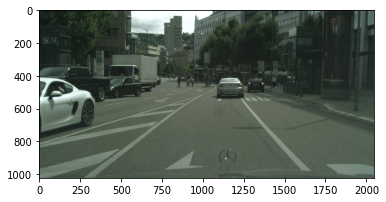

In [21]:
plt.imshow(EXAMPLE_IMAGE[:, :, ::-1])

In [0]:
RAW_CLASS_MAPPING = [
    [0, [0, 0, 0]],
    [1, [128, 64, 128]],
    [2, [244, 35,232]],
    [3, [70, 70, 70]],
    [4, [102, 102, 156]],
    [5, [190, 153, 153]],
    [6, [153, 153, 153]],
    [7, [250, 170, 30]],
    [8, [220, 220, 0]],
    [9, [107, 142, 35]],
    [10, [152, 251, 152]],
    [11, [70, 130, 180]],
    [12, [220, 20, 60]],
    [13, [255, 0, 0]],
    [14, [0, 0, 142]],
    [15, [0, 0, 70]],
    [16, [0, 60, 100]],
    [17, [0, 80, 100]],
    [18, [0, 0, 230]],
    [19, [119, 11, 32]]
]

In [0]:
CLASS_MAPPING = ?

In [0]:
# rozwiązanie
CLASS_MAPPING = np.array(
    [e[1] for e in RAW_CLASS_MAPPING]
)

In [0]:
def prepare_segmentation_map(segmentator: Segmentator,
                             class_mapping: np.ndarray,
                             image: np.ndarray
                            ) -> np.ndarray:
    pass

In [0]:
# rozwiązanie

def prepare_segmentation_map(segmentator: Segmentator,
                             class_mapping: np.ndarray,
                             image: np.ndarray
                            ) -> np.ndarray:
    prediction = segmentator.get_segmentation_map(
        image=image
    )
    return class_mapping[prediction].astype(np.uint8)

In [0]:
result = prepare_segmentation_map(
    segmentator=segmentator,
    class_mapping=CLASS_MAPPING,
    image=EXAMPLE_IMAGE
)

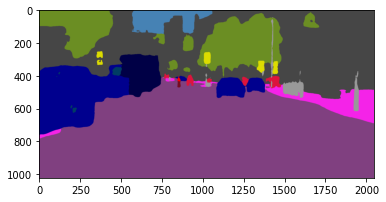

In [27]:
plt.imshow(result)

## Zadanie 2.

Aby wygodnie przedstawiać wyniki dobrze jest być w stanie nałożyć mapę segmentacji na wejściowy obraz.
Przygoruj implementację stosownej funkcji. Nie zapomnij, że kolory mapowania podane są w RGB, natomiast OpenCV używa BGR (w ten sposób był trenowany model). Wyjściowym formatem powinno być BGR!

_HINT: Poszukaj w dokumentacji OpenCV stosownej funkcji. Zauważ, że chcielibyśmy po prostu wartość każdego piksela obrazu wejściowego zmieszać z wartością mapy segmentacji w odpowiednich proporcjach. Operacja ta to po prostu średnia ważona koloru pikseli w obrazie wejściowym i mapie segmentacji._

In [0]:
def blend_input_with_segmentation_map(input_image: np.ndarray,
                                      segmentation_map: np.ndarray,
                                      image_visibility: float
                                     ) -> np.ndarray:
    """image_visibility - values from [0.0, 1.0]"""
    pass

In [0]:
# rozwiązanie

def blend_input_with_segmentation_map(input_image: np.ndarray,
                                      segmentation_map: np.ndarray,
                                      image_visibility: float
                                     ) -> np.ndarray:
    """image_visibility - values from [0.0, 1.0]"""
    segmentation_map = segmentation_map[:, :, ::-1]
    return cv.addWeighted(
        input_image,
        image_visibility, 
        segmentation_map,
        1 - image_visibility,
        0
    )

In [0]:
overlay = blend_input_with_segmentation_map(
    input_image=EXAMPLE_IMAGE,
    segmentation_map=result,
    image_visibility=0.5
)

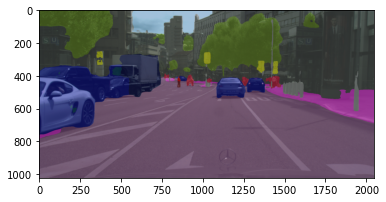

In [31]:
# BGR -> RGB as plt operates on RGB
plt.imshow(overlay[:, :, ::-1])

## Zadanie 3.

Uzupełnij kod, który wykonuje inferencje z modelu na strumieniu video i zapisuje wynik do pliku. Nie licz czasu zapisu klatki ani przeplotku mapy segmentacji z wejściowym obrazem do czasu inferencji.

In [0]:
INPUT_VIDEO_PATH = "./big_stuttgart_01.avi"
OUTPUT_VIDEO_PATH = "./output_video.avi"

In [0]:
def infer_on_video_stream(input_path: str,
                          output_path: str,
                          segmentator: Segmentator
                         ) -> None:
    inferences_time = []
    sink = _initialize_sink(output_path=output_path)
    for frame in tqdm(generate_frames(input_path)):
        start = time.time()
        ### YOUR CODE HERE
        inference_time = time.time() - start
        inferences_time.append(inference_time)
    sink.release()
    print(
        f"Inference time: {np.mean(inferences_time)} "
        f"+/- {np.std(inferences_time)} [s]"
    )


def generate_frames(input_path: str
                   ) -> Generator[np.ndarray, None, None]:
    video = cv.VideoCapture(input_path)
    while True:
        success, frame = video.read()
        if not success or frame is None:
            break
        yield frame
    

def _initialize_sink(output_path: str) -> cv.VideoWriter:
    return cv.VideoWriter(
        output_path,
        cv.VideoWriter_fourcc(*'DIVX'),
        25,
        (2048, 1024)
    )

In [0]:
# rozwiązanie

def infer_on_video_stream(input_path: str,
                          output_path: str,
                          segmentator: Segmentator
                         ) -> None:
    inferences_time = []
    sink = _initialize_sink(output_path=output_path)
    for frame in tqdm(generate_frames(input_path)):
        start = time.time()
        segmentation_result = prepare_segmentation_map(
            segmentator=segmentator,
            class_mapping=CLASS_MAPPING,
            image=frame
        )
        inference_time = time.time() - start
        overlay =  blend_input_with_segmentation_map(
            input_image=frame,
            segmentation_map=segmentation_result,
            image_visibility=0.5
        )
        sink.write(overlay)
        inferences_time.append(inference_time)
    sink.release()
    print(
        f"Inference time: {np.mean(inferences_time)} "
        f"+/- {np.std(inferences_time)} [s]"
    )


def generate_frames(input_path: str
                   ) -> Generator[np.ndarray, None, None]:
    video = cv.VideoCapture(input_path)
    while True:
        success, frame = video.read()
        if not success or frame is None:
            break
        yield frame
    

def _initialize_sink(output_path: str) -> cv.VideoWriter:
    return cv.VideoWriter(
        output_path,
        cv.VideoWriter_fourcc(*'DIVX'),
        25,
        (2048, 1024)
    )

In [35]:
infer_on_video_stream(
    input_path=INPUT_VIDEO_PATH,
    output_path=OUTPUT_VIDEO_PATH,
    segmentator=segmentator
)

603it [02:08,  4.69it/s]

Inference time: 0.1595777330509268 +/- 0.004163256202670044 [s]


### Pobierz wynik na swój komputer

In [0]:
from google.colab import files
files.download(OUTPUT_VIDEO_PATH) 